In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import f_oneway

In [106]:
claims = pd.read_csv('claims.csv')
cust_demographics = pd.read_csv('cust_demographics.csv')

In [107]:
claims

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1.0,No
1,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3.0,No
2,53522022,30308357,Other driver error,02/02/2018,Auto,No,Material only,$3369.5,1.0,Yes
3,13015401,47830476,Natural causes,06/17/2018,Auto,No,Material only,$1680,1.0,No
4,22890252,19269962,Crime,01/13/2018,Auto,No,Material only,$2680,1.0,No
...,...,...,...,...,...,...,...,...,...,...
1095,97727122,35951012,Other driver error,06/11/2017,Auto,No,Material only,$3059,4.0,Yes
1096,10247193,14818669,Natural causes,03/14/2018,Auto,No,Material only,$1520,2.0,No
1097,79807493,85322831,Other driver error,02/09/2018,Auto,No,Material and injury,$23575,2.0,Yes
1098,69299345,73449366,Other causes,03/21/2018,Auto,Unknown,Material and injury,$25120,1.0,No


In [108]:
cust_demographics

,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver
3,47830476,Female,01-May-86,MA,413-187-7945,Silver
4,19269962,Male,13-May-77,NV,956-871-8691,Gold
...,...,...,...,...,...,...
1080,79539873,Female,15-Mar-81,ND,459-425-4319,Platinum
1081,42364152,Female,07-Jul-96,ID,529-462-1635,Silver
1082,19888166,Male,11-Apr-90,WI,712-651-9613,Gold
1083,11256802,Female,22-Oct-64,LA,469-345-5617,Silver


#### 1. importing files

In [109]:
cust_demographics.rename(columns={'CUST_ID': 'customer_id'}, inplace=True)

# Merge the two DataFrames on 'customer_id'
combined_data = pd.merge(claims, cust_demographics, on='customer_id', how='left')

# Display the first few rows of the combined DataFrame to verify the merge
print("\nCombined Data:")
print(combined_data.head())

# Optionally save the combined data for further analysis
combined_data.to_csv('combined_data.csv', index=False)



Combined Data:
   claim_id  customer_id      incident_cause  claim_date claim_area  \
0  54004764     21868593        Driver error  11/27/2017       Auto   
1  33985796     75740424               Crime  10/03/2018       Home   
2  53522022     30308357  Other driver error  02/02/2018       Auto   
3  13015401     47830476      Natural causes  06/17/2018       Auto   
4  22890252     19269962               Crime  01/13/2018       Auto   

  police_report     claim_type claim_amount  total_policy_claims fraudulent  \
0            No  Material only        $2980                  1.0         No   
1       Unknown  Material only        $2980                  3.0         No   
2            No  Material only      $3369.5                  1.0        Yes   
3            No  Material only        $1680                  1.0         No   
4            No  Material only        $2680                  1.0         No   

   gender DateOfBirth State       Contact   Segment  
0  Female   12-Jan-79    VT 

#### 2.  Data audit for the datatypes 

In [110]:
# Check the current datatypes of the columns
print(combined_data.dtypes)

# Convert datatypes where necessary
combined_data['claim_id'] = combined_data['claim_id'].astype(int)
combined_data['customer_id'] = combined_data['customer_id'].astype(int)
combined_data['claim_date'] = pd.to_datetime(combined_data['claim_date'], format='%m/%d/%Y')
combined_data['claim_amount'] = combined_data['claim_amount'].replace('[\$,]', '', regex=True).astype(float)
combined_data['total_policy_claims'] = combined_data['total_policy_claims'].astype(float)
combined_data['DateOfBirth'] = pd.to_datetime(combined_data['DateOfBirth'], format='%d-%b-%y')

# Verify the changes
print("\nchanged datatypes:\n",combined_data.dtypes)


claim_id                 int64
customer_id              int64
incident_cause          object
claim_date              object
claim_area              object
police_report           object
claim_type              object
claim_amount            object
total_policy_claims    float64
fraudulent              object
gender                  object
DateOfBirth             object
State                   object
Contact                 object
Segment                 object
dtype: object

changed datatypes:
 claim_id                        int32
customer_id                     int32
incident_cause                 object
claim_date             datetime64[ns]
claim_area                     object
police_report                  object
claim_type                     object
claim_amount                  float64
total_policy_claims           float64
fraudulent                     object
gender                         object
DateOfBirth            datetime64[ns]
State                          object
Contac

#### 3. Converting the column claim_amount to numeric

In [111]:
combined_data['claim_amount'] = combined_data['claim_amount'].replace('[\$,]', '', regex=True).astype(float)

# Display the first few rows to verify the conversion
print("\nAfter conversion:")
print(combined_data['claim_amount'].head())

# Verify the datatype of the column
print("\nData type of claim_amount:")
print(combined_data['claim_amount'].dtype)



After conversion:
0    2980.0
1    2980.0
2    3369.5
3    1680.0
4    2680.0
Name: claim_amount, dtype: float64

Data type of claim_amount:
float64


#### 4. Creating Flags

In [112]:
injury_claims = combined_data[combined_data['claim_type'] == 'Material and injury']

unreported_with_police = injury_claims['police_report'] == 'No'

combined_data['alert_flag'] = 0 
combined_data.loc[injury_claims.index[unreported_with_police], 'alert_flag'] = 1

print(combined_data[['claim_type', 'police_report', 'alert_flag']].head())

      claim_type police_report  alert_flag
0  Material only            No           0
1  Material only       Unknown           0
2  Material only            No           0
3  Material only            No           0
4  Material only            No           0


#### 5. Duplicate removing

In [113]:
combined_data_sorted = combined_data.sort_values(by=['customer_id', 'claim_date'], ascending=[True, False])

combined_data_unique = combined_data_sorted.drop_duplicates(subset='customer_id', keep='first')

duplicates_removed = combined_data_unique.duplicated(subset='customer_id', keep=False).sum()
print("Number of duplicated records after removal:", duplicates_removed)

print(combined_data_unique.head())


Number of duplicated records after removal: 0
     claim_id  customer_id      incident_cause claim_date claim_area  \
184  69348631       154557        Driver error 2018-04-10       Auto   
836  40953049       263204        Other causes 2018-04-04       Auto   
677  45780237       287476      Natural causes 2017-10-17       Auto   
828  89833962       441097        Other causes 2018-03-21       Auto   
505  35782742       524545  Other driver error 2018-07-27       Auto   

    police_report           claim_type  claim_amount  total_policy_claims  \
184            No          Injury only           NaN                  1.0   
836            No  Material and injury       39192.0                  1.0   
677       Unknown        Material only        1621.5                  2.0   
828           Yes  Material and injury       37040.0                  1.0   
505            No          Injury only       35250.0                  3.0   

    fraudulent  gender DateOfBirth State       Contact   S

#### 6. Checking for missing values and impute the missing values 

In [114]:
missing_values = combined_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

for column in combined_data.columns:
    if combined_data[column].dtype == 'object':
        mode_value = combined_data[column].mode()[0]
        combined_data[column].fillna(mode_value, inplace=True)
    else:
        mean_value = combined_data[column].mean()
        combined_data[column].fillna(mean_value, inplace=True)

missing_values_after_imputation = combined_data.isnull().sum()
print("\nMissing values after imputation:")
print(missing_values_after_imputation)


Missing values in each column:
claim_id                0
customer_id             0
incident_cause          0
claim_date              0
claim_area              0
police_report           0
claim_type              0
claim_amount           65
total_policy_claims    10
fraudulent              0
gender                 15
DateOfBirth            15
State                  15
Contact                15
Segment                15
alert_flag              0
dtype: int64

Missing values after imputation:
claim_id               0
customer_id            0
incident_cause         0
claim_date             0
claim_area             0
police_report          0
claim_type             0
claim_amount           0
total_policy_claims    0
fraudulent             0
gender                 0
DateOfBirth            0
State                  0
Contact                0
Segment                0
alert_flag             0
dtype: int64


#### 7. Age of customers in years 

In [115]:
combined_data['DateOfBirth'] = pd.to_datetime(combined_data['DateOfBirth'])

combined_data['Age'] = pd.to_datetime('now').year - combined_data['DateOfBirth'].dt.year

# Categorize customers based on age
def categorize_age(age):
    if age < 18:
        return 'Children'
    elif 18 <= age <= 30:
        return 'Youth'
    elif 30 < age <= 60:
        return 'Adult'
    else:
        return 'Senior'

combined_data['Age_Category'] = combined_data['Age'].apply(categorize_age)

print(combined_data[['DateOfBirth', 'Age', 'Age_Category']].head())

  DateOfBirth  Age Age_Category
0  1979-01-12   45        Adult
1  1970-01-13   54        Adult
2  1984-03-11   40        Adult
3  1986-05-01   38        Adult
4  1977-05-13   47        Adult


#### 8. Average amount claimed by the customers from various segaments

In [116]:
average_claim_amount_by_segment = combined_data.groupby('Segment')['claim_amount'].mean()
print(average_claim_amount_by_segment)

Segment
Gold        12746.446802
Platinum    12340.893306
Silver      12206.379320
Name: claim_amount, dtype: float64


#### 9.  total claim amount based on incident cause for all the claims that have been done at least 20 days prior to 1st of October, 20188

In [117]:
combined_data['claim_date'] = pd.to_datetime(combined_data['claim_date'])
filtered_data = combined_data[combined_data['claim_date'] <= pd.Timestamp('2018-10-01') - pd.Timedelta(days=20)]
total_claim_amount_by_cause = filtered_data.groupby('incident_cause')['claim_amount'].sum()
total_claim_amount_by_cause

incident_cause
Crime                 7.294726e+05
Driver error          3.348656e+06
Natural causes        1.316441e+06
Other causes          3.779869e+06
Other driver error    3.384045e+06
Name: claim_amount, dtype: float64

#### 10. adults from TX, DE and AK claimed insurance for driver related issues and causes

In [118]:
adults_tx_de_ak = combined_data[(combined_data['State'].isin(['TX', 'DE', 'AK'])) & (combined_data['Age'] >= 30) & (combined_data['Age'] <= 60)]
driver_related_claims = adults_tx_de_ak[adults_tx_de_ak['incident_cause'].str.contains('driver', case=False)]
claim_count_by_state = driver_related_claims.groupby('State').size()
print(claim_count_by_state)

State
AK    9
DE    9
TX    7
dtype: int64


#### 11. pie chart between the aggregated value of claim amount based on gender and segmentt

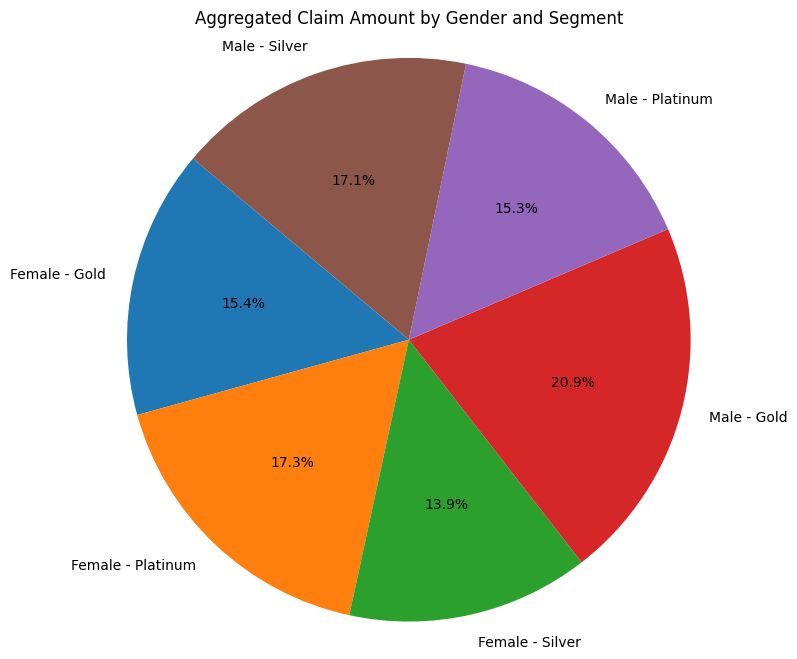

In [119]:
grouped_data = combined_data.groupby(['gender', 'Segment'])['claim_amount'].sum().reset_index()

plt.figure(figsize=(8, 8))
plt.pie(grouped_data['claim_amount'], labels=grouped_data.apply(lambda x: f"{x['gender']} - {x['Segment']}", axis=1), autopct='%1.1f%%', startangle=140)
plt.title('Aggregated Claim Amount by Gender and Segment')
plt.axis('equal') 
plt.show()


#### 12.  Among males and females, which gender had claimed the most for any type of driver related issuess

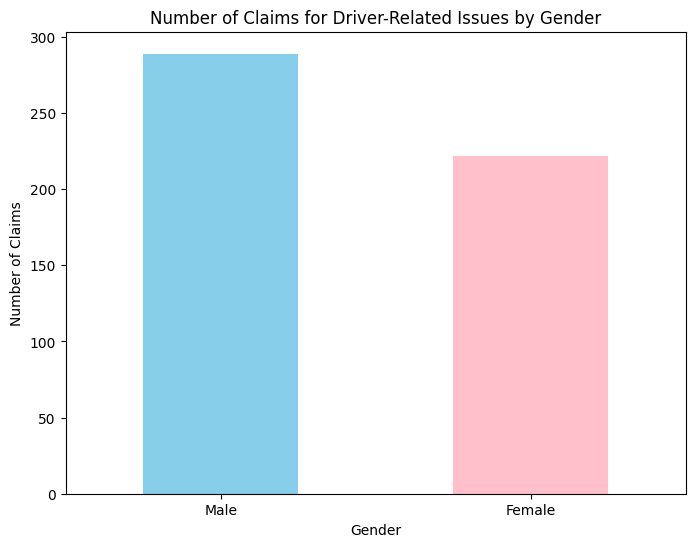

In [120]:
driver_related_claims = combined_data[combined_data['incident_cause'].str.contains('driver', case=False)]

gender_claim_counts = driver_related_claims['gender'].value_counts()

plt.figure(figsize=(8, 6))
gender_claim_counts.plot(kind='bar', color=['skyblue', 'pink'])
plt.title('Number of Claims for Driver-Related Issues by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Claims')
plt.xticks(rotation=0)
plt.show()


#### 13. Which age group had the maximum fraudulent policy claims

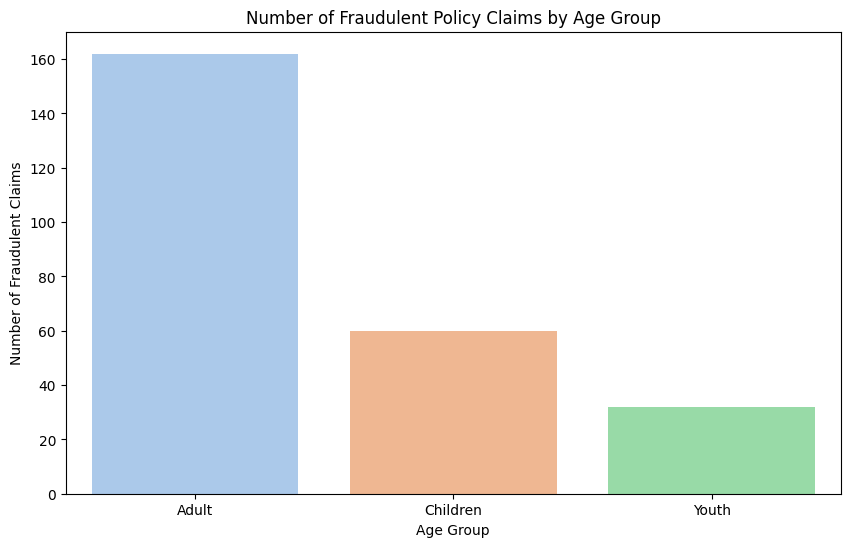

In [121]:
def categorize_age(age):
    if age < 18:
        return 'Children'
    elif 18 <= age < 30:
        return 'Youth'
    elif 30 <= age < 60:
        return 'Adult'
    else:
        return 'Senior'

combined_data['Age_Group'] = combined_data['Age'].apply(categorize_age)

fraudulent_claims = combined_data[combined_data['fraudulent'] == 'Yes']

fraudulent_age_counts = fraudulent_claims['Age_Group'].value_counts().reset_index()
fraudulent_age_counts.columns = ['Age_Group', 'Number of Fraudulent Claims']

plt.figure(figsize=(10, 6))
sns.barplot(x='Age_Group', y='Number of Fraudulent Claims', hue='Age_Group', data=fraudulent_age_counts, palette='pastel')
plt.title('Number of Fraudulent Policy Claims by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Fraudulent Claims')
plt.show()


#### 14.  monthly trend of the total amount that has been claimed by the customerss

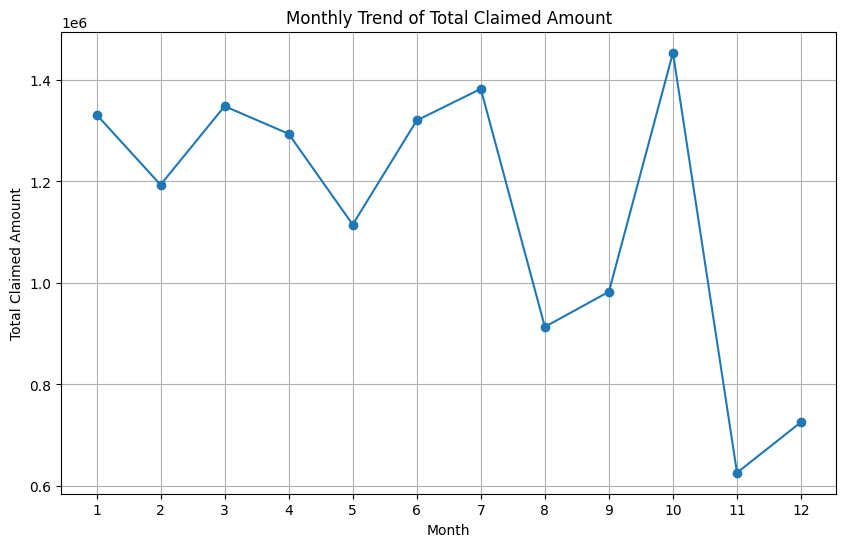

In [130]:
combined_data['Month'] = combined_data['claim_date'].dt.month
monthly_claim_amount = combined_data.groupby('Month')['claim_amount'].sum().reset_index()
monthly_claim_amount = monthly_claim_amount.sort_values('Month')

plt.figure(figsize=(10, 6))
plt.plot(monthly_claim_amount['Month'], monthly_claim_amount['claim_amount'], marker='o')
plt.title('Monthly Trend of Total Claimed Amount')
plt.xlabel('Month')
plt.ylabel('Total Claimed Amount')
plt.xticks(range(1, 13))  
plt.grid(True)
plt.show()



#### 15.  average claim amount for gender and age categories 

#### Average Claim Amount by Gender and Age Group

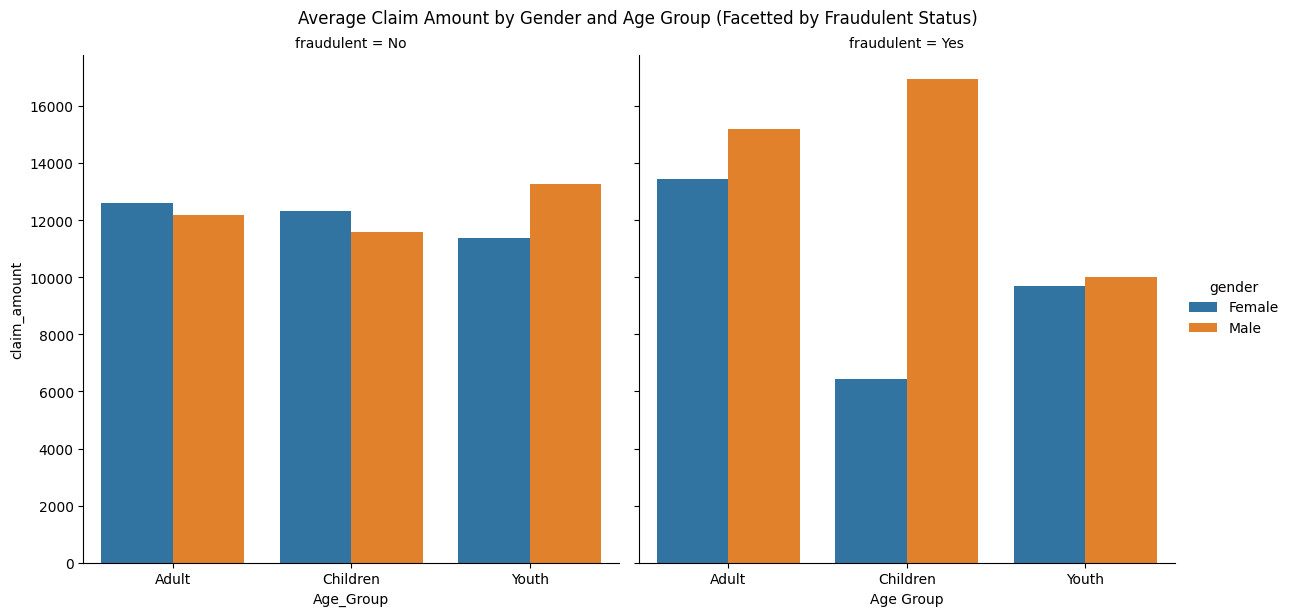

In [123]:
average_claim_amount = combined_data.groupby(['gender', 'Age_Group', 'fraudulent'])['claim_amount'].mean().reset_index()

sns.catplot(x='Age_Group', y='claim_amount', hue='gender', data=average_claim_amount, kind='bar', col='fraudulent', height=6, aspect=1)
plt.suptitle('Average Claim Amount by Gender and Age Group (Facetted by Fraudulent Status)', y=1.02)
plt.xlabel('Age Group')
plt.ylabel('Average Claim Amount')
plt.show()


In [124]:
fraudulent_data = combined_data[combined_data['fraudulent'] == 'Yes']
non_fraudulent_data = combined_data[combined_data['fraudulent'] == 'No']

# Perform ANOVA test for fraudulent claims
anova_fraudulent = f_oneway(
    *[fraudulent_data[fraudulent_data['Age_Group'] == group]['claim_amount'] for group in fraudulent_data['Age_Group'].unique()]
)
p_value_fraudulent = anova_fraudulent[1]

# Perform ANOVA test for non-fraudulent claims
anova_non_fraudulent = f_oneway(
    *[non_fraudulent_data[non_fraudulent_data['Age_Group'] == group]['claim_amount'] for group in non_fraudulent_data['Age_Group'].unique()]
)
p_value_non_fraudulent = anova_non_fraudulent[1]

print("P-value for fraudulent claims ANOVA test:", p_value_fraudulent)
print("P-value for non-fraudulent claims ANOVA test:", p_value_non_fraudulent)


P-value for fraudulent claims ANOVA test: 0.13827357500880064
P-value for non-fraudulent claims ANOVA test: 0.9128966767519269


#### 16. Is there any similarity in the amount claimed by males and females

In [125]:
claim_amount_male = combined_data[combined_data['gender'] == 'Male']['claim_amount']
claim_amount_female = combined_data[combined_data['gender'] == 'Female']['claim_amount']

t_statistic, p_value = ttest_ind(claim_amount_male, claim_amount_female, equal_var=False)

alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in the amount claimed by males and females.")
else:
    print("There is no significant difference in the amount claimed by males and females.")


There is no significant difference in the amount claimed by males and females.


#### 17. Is there any relationship between age category and segment

In [126]:
contingency_table = pd.crosstab(combined_data['Age_Group'], combined_data['Segment'])

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

alpha = 0.05
if p_value < alpha:
    print("There is a significant relationship between age category and segment.")
else:
    print("There is no significant relationship between age category and segment.")


There is no significant relationship between age category and segment.


#### 18.  current year has shown a significant rise in claim amounts as compared to 2016-17 fiscal average which was $10,000..

In [127]:
mu_0 = 10000

sample_claim_amounts = [10000, 11000, 12000, 13000, 14000]  # Replace with actual claim amounts

t_statistic, p_value = ttest_1samp(sample_claim_amounts, mu_0)

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant rise in claim amounts compared to the 2016-17 fiscal average.")
else:
    print("Fail to reject the null hypothesis. There is no significant rise in claim amounts compared to the 2016-17 fiscal average.")



Reject the null hypothesis. There is a significant rise in claim amounts compared to the 2016-17 fiscal average.


#### 19. Is there any difference between age groups and insurance claims

In [128]:
claim_amounts_age_group = {
    'Children': [1000, 2000, 1500, 1800],
    'Youth': [2500, 2200, 2700, 3000],
    'Adult': [3500, 3800, 4000, 4200],
    'Senior': [5000, 5500, 5200, 4800]
}

f_statistic, p_value = f_oneway(*claim_amounts_age_group.values())

alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in insurance claims across different age groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in insurance claims across different age groups.")


Reject the null hypothesis. There is a significant difference in insurance claims across different age groups.


#### 20. Is there any relationship between total number of policy claims and the claimed amountt

In [129]:
total_policy_claims = [2, 3, 4, 5, 6]
claim_amount = [1000, 1500, 2000, 2500, 3000]

corr_coeff, p_value = pearsonr(total_policy_claims, claim_amount)

alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant correlation between the total number of policy claims and the claimed amount.")
else:
    print("Fail to reject the null hypothesis. There is no significant correlation between the total number of policy claims and the claimed amount.")

print("Pearson correlation coefficient:", corr_coeff)


Reject the null hypothesis. There is a significant correlation between the total number of policy claims and the claimed amount.
Pearson correlation coefficient: 1.0
